# Simple Model 2

In [1]:
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import random

"""Change to the data folder"""
new_path = "./new_train/new_train/"

val_path = "./new_val_in/new_val_in/"

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        random.shuffle(self.pkl_list)
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data
    
    def capIt(self, a, b):
        self.pkl_list = self.pkl_list[a:b]


# intialize a dataset
train_dataset  = ArgoverseDataset(data_path=new_path)
test_dataset = ArgoverseDataset(data_path=new_path)
val_dataset  = ArgoverseDataset(data_path=val_path)

In [3]:
len(train_dataset)

205942

In [4]:
train_dataset.capIt(0,200000)

In [5]:
test_dataset.capIt(201000,202008)

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

    

GPU is available


In [7]:
batch_sz = 16

def collateInput(batch):
    """ collate lists of samples into batches, create  """
    
    '''
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    index = [i for i in range(60) for scene in batch if scene['agent_id'] == scene['track_id'][i, 0, 0]]
    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out, index]
    '''
    inp = []
    out = []
    index = []
    for scene in batch:
        inp = inp + [[scene['p_in'][i]] for i in range(60) if scene['track_id'][i, 0, 0] == scene['agent_id']]
        out = out + [[scene['p_out'][i]] for i in range(60) if scene['track_id'][i, 0, 0] == scene['agent_id']]
        index = index + [i for i in range(60) if scene['agent_id'] == scene['track_id'][i, 0, 0]]
    inp = torch.FloatTensor(inp).squeeze(1)
    out = torch.FloatTensor(out).squeeze(1)

    return[inp, out, index]

train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = True, collate_fn=collateInput, num_workers=0)
test_loader = DataLoader(test_dataset,batch_size=batch_sz, shuffle = True, collate_fn=collateInput, num_workers=0)




In [10]:
#Normalize
'''
sumX = 0
sumY = 0
total = 0
batch_size = 16
for [inp, out, index] in train_loader:
    total = total + (batch_size * 19 * 2)
    sumX = sumX + inp[:, :, 0].sum() + out[:, :, 0].sum()
    sumY = sumY + inp[:, :, 1].sum() + out[:, :, 1].sum()
meanX = sumX/total
meanY = sumY/total

print("half done")

sqX = 0
sqY = 0
a = torch.zeros(batch_size, 19)
a[:, :] = meanX
b[:, :] = meanY
for [inp, out, index] in train_loader:
    sqX = sqX + (torch.square(inp[:, :, 0] - a)).sum().item()
    sqY = sqY + (torch.square(inp[:, :, 1] - a)).sum().item()
    
stdX = torch.sqrt(sqX/total)
stdY = torch.sqrt(sqY/total)
print(meanX, meanY, stdX, stdY)
'''
max = 0
min = 0
for [inp, out, index] in train_loader:        
        if (torch.max(inp) > max):
            max = torch.max(inp)
           
        if (torch.min(inp) < min):
            min = torch.min(inp)
            
        if (torch.max(out) > max):
            max = (torch.max(out))
                   
                
        if (torch.min(out) < min):
            min = torch.min(out)
            
            

print(max)
print(min)
maxVal = 4744.3594

tensor(4744.3594, device='cpu')
0


In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

class RNNEncoder(nn.Module):

    def __init__(self, i_size, h_size, n_layers, batchsize):
        super().__init__()
        
        self.i_size = i_size
        self.h_size = h_size
        self.n_layers = n_layers
        self.batch_size = batchsize
        self.encoder = nn.LSTM(self.i_size, h_size, n_layers, batch_first=True)
        self.fc_out = nn.Linear(self.h_size, i_size)
        self.batchNorm = nn.BatchNorm1d(19)
        
    def forward(self, x):
        batch_size = x.size(0)
        h = self.init_hidden(self.batch_size, self.n_layers, self.h_size)
        c = self.init_hidden(self.batch_size, self.n_layers, self.h_size)
        x.to(device)
        out, (hidden, cellstate) = self.encoder(x, (h, c))
        #out = self.batchNorm(out)
        out = F.tanh(self.fc_out(out))
        #out = self.batchNorm(out)
        return out, hidden, cellstate
    
    def init_hidden(self, batch_size, n_layers, hidden_dim):
        hidden = torch.zeros(n_layers, batch_size, hidden_dim).to(device)
        return hidden

In [9]:
class RNNDecoder(nn.Module):

    def __init__(self, o_size, h_size, n_layers, batchSize):
        super().__init__()
        
        
        self.o_size = o_size
        self.h_size = h_size
        self.n_layers = n_layers
        self.decoder = nn.LSTM(self.o_size, h_size, n_layers, batch_first=True)
        self.fc_out = nn.Linear(self.h_size , self.o_size)
        #self.batchNorm = nn.BatchNorm1d(1)
        #self.batchNorm2 = nn.BatchNorm1d(2)


        
    def forward(self, x, h):
        batch_size = x.size(0)
        out, (hidden, cellstate) = self.decoder(x, h)
        #out = self.batchNorm(out)
        out = F.relu(self.fc_out(out.reshape((batch_size, -1))))
        #out = self.batchNorm2(out)
        
        return out, hidden, cellstate
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        return hidden

In [10]:
class RNNendec(nn.Module):
    def __init__(self, enc, enc2, dec, dec2, numOutputs, numFeatures, batchSize):
        super().__init__()
        
        self.encoder = enc
        self.encoder2 = enc2
        self.decoder = dec
        self.decoder2 = dec2
        self.numO = numOutputs
        self.feat = numFeatures
        self.batchSize = batchSize
        
    def forward(self, x, target, teacher_force_ratio = 0.5):
        
        seqLen = x.size(1)
        batchSize = x.size(0)
        features = x.size(2)
        
        
        outputTensor = torch.zeros(batchSize, self.numO, self.feat)
        
        
        o, h, c = self.encoder(x[:,:,0 ].reshape(batchSize, 19,1))
        o2, h2, c2, = self.encoder(x[:, :, 1].reshape(batchSize, 19, 1))
        
        o = o.reshape(batchSize, 19, 1)
        # first input to decoder is last output of encoder
        t = o[:, 18, :].reshape(batchSize, 1, 1)
        
        for i in range(self.numO):
            o, h, c = self.decoder(t , (h, c))
            
            #update output tensor
            o = o.reshape(self.batchSize, 1)
            
            
            outputTensor[:, i, 0] = o.reshape(batchSize)
            
            
            # set next input to be either correct from target or prediction
            #target is a flag, when zero, we are doing predictions
            if target.size() != torch.Size([1]):
                #t = target[:, i, :].reshape(batchSize, 1, 1) 
                if random.random() < teacher_force_ratio: 
                    t = target[:, i, 0].reshape(batchSize, 1, 1) 
                else:
                    t = o.reshape(batchSize, 1, 1)
            else:
                t = o.reshape(batchSize, 1, 1)
                
            
            
            
            
            
        o2 = o2.reshape(batchSize, 19, 1)
        # first input to decoder is last output of encoder
        t2 = o2[:, 18, :].reshape(batchSize, 1, 1)
        
        for i in range(self.numO):
            o2, h2, c2 = self.decoder(t2 , (h2, c2))
            
            #update output tensor
            o2 = o2.reshape(self.batchSize, 1)
            
            
            outputTensor[:, i, 1] = o2.reshape(batchSize)
            
            
            # set next input to be either correct from target or prediction
            #target is a flag, when zero, we are doing predictions
            if target.size() != torch.Size([1]):
                
                if random.random() < teacher_force_ratio: 
                    t2 = target[:, i, 1].reshape(batchSize, 1, 1) 
                else:
                    t2 = o2.reshape(batchSize, 1, 1)
                    #t = target[:, i, :].reshape(batchSize, 1, 1) 
            else:
                    t2 = o2.reshape(batchSize, 1, 1)
                
                
        return outputTensor
    
    def init_hidden(self, batch_size, n_layers, hidden_dim):
        hidden = torch.zeros(n_layers, batch_size, hidden_dim).to(device)
        return hidden

In [11]:

is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

    

#Hyperparameters

inputFeat = 1
outputFeat = 1
numFeat = 2
hiddenFeat = 4
batchSize = 16
outputSeqLen = 30
numLayers = 1

maxVal = 4736.1733
enc = RNNEncoder(inputFeat, hiddenFeat, numLayers, batchSize)
enc2 = RNNEncoder(inputFeat, hiddenFeat, numLayers, batchSize)
enc.to(device)
enc2.to(device)
dec = RNNDecoder(outputFeat, hiddenFeat, numLayers, batchSize)
dec2 = RNNDecoder(outputFeat, hiddenFeat, numLayers, batchSize)
dec.to(device)
dec2.to(device)

model = RNNendec(enc, enc2, dec, dec2,  outputSeqLen, numFeat, batchSize)
model.to(device)

n_epochs = 5
lr=0.001


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-4)
criterion.to(device)

GPU is available


MSELoss()

In [12]:
from tqdm import tqdm_notebook as tqdm

losses = []


def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    iterator = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (inp, target, index) in enumerate(iterator):
        inp, target = inp.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        a = torch.zeros(1)
        
        inp = inp/maxVal
        target = target/maxVal
        
        output = model(inp, target)

   
        output.to(device)
        target.to(device)
        loss = criterion(output * maxVal, target * maxVal)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        counter += 1
        iterator.set_postfix(loss=(loss.item()*inp.size(0) / (counter * train_loader.batch_size)))
        
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    i = 0
    with torch.no_grad():
        for inp, target, index in test_loader:
            inp, target = inp.to(device), target.to(device)
            
            inp = inp/maxVal
            target = target/maxVal
            a = torch.zeros(1)
            output = model(inp, a)

             #reshape output and target to check loss only on agent car

            test_loss += criterion(output * maxVal, target * maxVal)# sum up batch loss
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
model.load_state_dict(torch.load('./simpleEncDec'))

<All keys matched successfully>

In [63]:
# Training Run
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    break
    
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: 

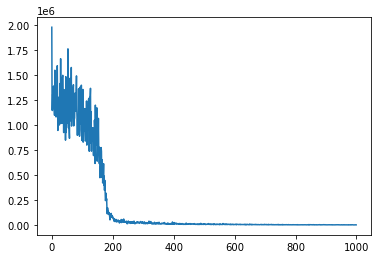

In [22]:
from matplotlib import pyplot as plt

time = numpy.arange(1000)
plt.plot(time, losses[:1000])

In [61]:
batch_sz = 16


def collateVal(batch):

    inp = []
    index = []
    scene1 = []
    for scene in batch:
        inp = inp + [[scene['p_in'][i]] for i in range(60) if scene['track_id'][i, 0, 0] == scene['agent_id']]
        index = index + [i for i in range(60) if scene['agent_id'] == scene['track_id'][i, 0, 0]]
        scene1 = scene1 + [scene['scene_idx']]
    inp = torch.FloatTensor(inp).squeeze(1)

    return[inp, index, scene1]



val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = True, collate_fn=collateVal, num_workers=0)


In [62]:
## test file writing
import csv



header = ['ID','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16','v17','v18',
          'v19','v20','v21','v22','v23','v24','v25','v26','v27','v28','v29','v30','v31','v32','v33','v34','v35'
          ,'v36','v37','v38','v39','v40','v41','v42','v43','v44','v45','v46','v47','v48','v49','v50','v51','v52',
          'v53','v54','v55','v56','v57','v58','v59','v60']

with open('./submission.csv', mode = 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(header)

    
    
    for inp, index, scene in val_loader:
        inp  = inp.to(device)
        
        inp = inp/maxVal
        a = torch.zeros(1)
        output = model(inp, a)
 
        output = output * maxVal
         #reshape output and target to check loss only on agent car

        for i in range(batch_sz):
            writeLine = []
            writeLine.append(str(scene[i]))
            temp = output.reshape(batch_sz, 60)
            
            temp = temp[i]
            
            writeLine = writeLine + temp.tolist()
        
            if(len(writeLine) != 61):
                print("list error")
                
            writer.writerow(writeLine)
            #print(index)
        
        
print("Finished Writing")


Finished Writing


In [17]:
torch.save(model.state_dict(), './simpleEncDec')

Make sample predictions

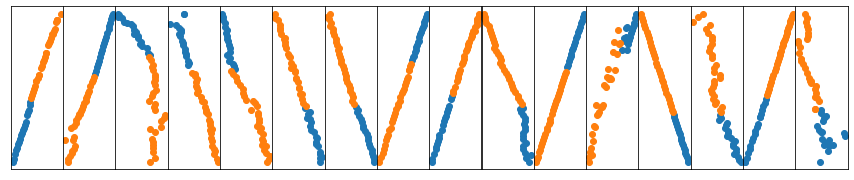

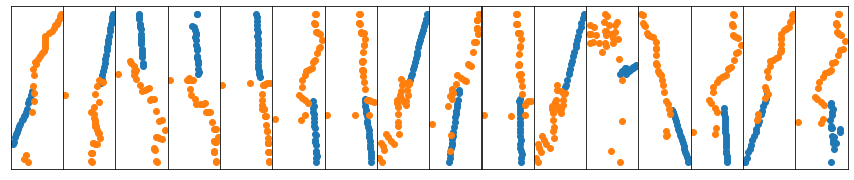

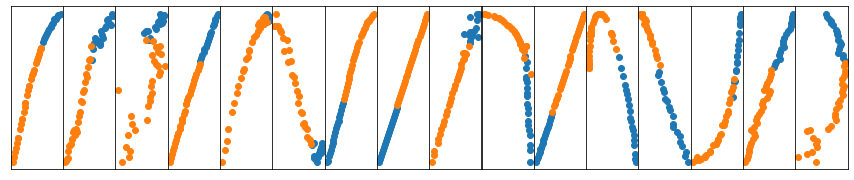

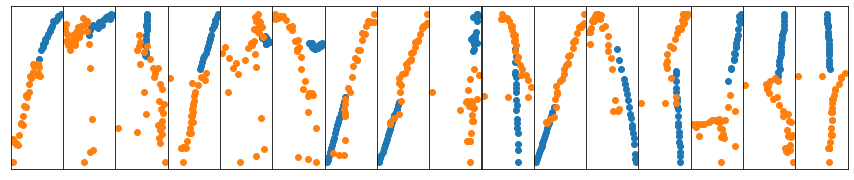

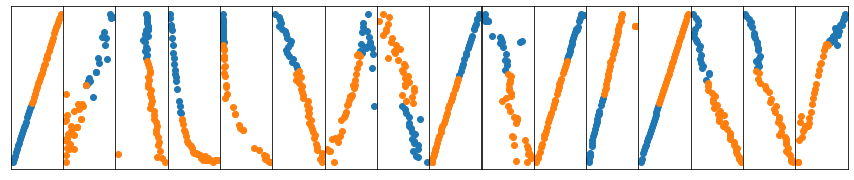

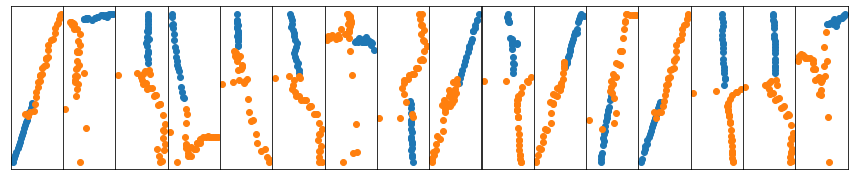

In [66]:
import matplotlib.pyplot as plt
import random

agent_id = 0
def show_sample_batch(inp , out, agent_id, output):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = inp, out
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    inp = inp.to('cpu')
    out = out.to('cpu')
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
   
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])
        
        
    fig2, axs2 = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig2.subplots_adjust(hspace = .5, wspace=.001)
    axs2 = axs2.ravel()   
    for i in range(batch_sz):
        axs2[i].xaxis.set_ticks([])
        axs2[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs2[i].scatter(inp[i,:,0], inp[i,:,1])
        axs2[i].scatter(output[i,:,0], output[i,:,1])


k = 0
for i_batch, sample_batch in enumerate(test_loader):
    inp, out, index = sample_batch
    inp = inp.to(device)
    out = out.to(device)
    inp = inp/maxVal
    out = out/maxVal
    #print(inp.size())
    #print(out.size())
    k = k+1
    """TODO:
      Deep learning model
      training routine
    """
    output = model(inp, out)
    output = output.to('cpu')
    output = output.detach().numpy()
    a = torch.zeros(1)
    show_sample_batch(inp * maxVal, out * maxVal, agent_id, output * maxVal)
    if k == 3:
        break

# Simple FC network

In [162]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

device = 'cuda'

class fcNetwork(nn.Module):

    def __init__(self, i_size, o_size, n_layers, batchsize):
        super().__init__()
        
        self.fc_out = nn.Linear(i_size * 2, o_size * 2)
        
        
    def forward(self, x):
        
        out = F.relu(self.fc_out(x))
        return out
        
    def init_hidden(self, batch_size, n_layers, hidden_dim):
        hidden = torch.zeros(n_layers, batch_size, hidden_dim).to(device)
        return hidden

In [163]:
batch_sz = 16
def collateFC(batch):

    inp = []
    out = []
    index = []
    for scene in batch:
        inp = inp + [[scene['p_in'][i]] for i in range(60) if scene['track_id'][i, 0, 0] == scene['agent_id']]
        out = out + [[scene['p_out'][i]] for i in range(60) if scene['track_id'][i, 0, 0] == scene['agent_id']]
        index = index + [i for i in range(60) if scene['agent_id'] == scene['track_id'][i, 0, 0]]
    inp = torch.FloatTensor(inp).squeeze(1)
    out = torch.FloatTensor(out).squeeze(1)

    return[inp, out, index]



fc_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = False, collate_fn=collateFC, num_workers=0)
fc_test = DataLoader(test_dataset,batch_size=batch_sz, shuffle = False, collate_fn=collateFC, num_workers=0)

In [164]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    iterator = tqdm(fc_loader, total=int(len(fc_loader)))
    counter = 0
    for batch_idx, (inp, target, index) in enumerate(iterator):
        inp, target = inp.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        a = torch.zeros(1)
        inp = inp.reshape(batchSize, -1)
        target = target.reshape(batchSize, -1)
        
        #inp = inp/maxVal
        #target = target/maxVal        
        output = model(inp)

   
        output.to(device)
        target.to(device)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        iterator.set_postfix(loss=(loss.item()*inp.size(0) / (counter * fc_loader.batch_size)))

In [165]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    i = 0
    with torch.no_grad():
        for inp, target, index in fc_test:
            inp, target = inp.to(device), target.to(device)
            
            inp = inp.reshape(batchSize, -1)
            target = target.reshape(batchSize, -1)
            #inp = inp/maxVal
            #target = target/maxVal
            a = torch.zeros(1)
            output = model(inp)

             #reshape output and target to check loss only on agent car

            test_loss += criterion(output , target)# sum up batch loss
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(fc_test.dataset),
        100. * correct / len(fc_test.dataset)))

In [166]:
newModel = fcNetwork(19, 30, 1, 16)
newModel = newModel.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-4)
criterion.to(device)

MSELoss()

In [167]:
# Training Run
for epoch in range(1, n_epochs + 1):
    train(newModel, device, fc_loader, optimizer, epoch)
    test(newModel, device, fc_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until




Test set: Average loss: 212205.9219, Accuracy: 0/1008 (0%)





Test set: Average loss: 212205.9219, Accuracy: 0/1008 (0%)



KeyboardInterrupt: 